# Метод линеаризации

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас) вида  𝑥/𝑦  (У нас likes/clicks).

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

Задача:

**1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?**

Данные берём в том же диапазоне, в котором проводился АБ-тест.

У нас есть 2 группы:
1. Группа 1 включает группы: 0(контрольная) и 3(тестовая)
2. Группа 2 включает группы: 1(контрольная) и 2(тестовая)

In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20231020',
              'user':'student',
              'password':'_'
             }

In [3]:
# Считаем общий CTR в контрольной группе 0 и линеаризованные лайки в группах 0 и 3

quest_linearixed = """
                        SELECT 
                            exp_group, 
                            user_id, 
                            likes, 
                            views, 
                            ctr, 
                            ctr_control, 
                            round(likes - (ctr_control * views), 2) as linearixed_likes
                        FROM
                          (
                          SELECT 
                              exp_group, 
                              user_id,
                              SUM(action = 'like') as likes,
                              SUM(action = 'view') as views,
                              round(likes/views, 2) as ctr
                          FROM 
                              simulator_20231020.feed_actions
                          WHERE 
                              toDate(time) BETWEEN '2023-09-28' AND '2023-10-04'
                              AND exp_group in (0, 3)
                          GROUP BY 
                              exp_group, 
                              user_id
                          ) as t1
                        CROSS JOIN
                          (
                          SELECT 
                              round(SUM(action = 'like')/SUM(action = 'view'), 2) as ctr_control
                          FROM 
                              simulator_20231020.feed_actions
                          WHERE 
                              toDate(time) BETWEEN '2023-09-28' AND '2023-10-04'
                              AND exp_group = 0
                          GROUP BY 
                              exp_group
                          ) as common_ctr 
                        """

df_linearixed_gr_1 = ph.read_clickhouse(quest_linearixed, connection=connection)
df_linearixed_gr_1.head()

,exp_group,user_id,likes,views,ctr,ctr_control,linearixed_likes
0,3,115383,12,44,0.27,0.21,2.76
1,3,123580,2,11,0.18,0.21,-0.31
2,0,4944,8,41,0.20,0.21,-0.61
3,0,4504,5,15,0.33,0.21,1.85
4,0,121508,6,25,0.24,0.21,0.75


<AxesSubplot:xlabel='ctr', ylabel='Count'>

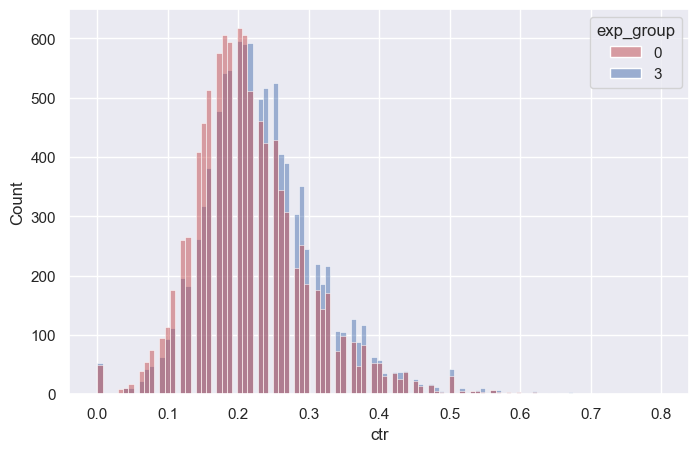

In [7]:
# Построим гистограммы распределения CTR по группам 0 и 3

sns.set(rc={'figure.figsize':(8, 5)})

sns.histplot(data=df_linearixed_gr_1, 
             x='ctr', 
             hue='exp_group', 
             palette=['r', 'b'], 
             alpha=0.5, 
             kde=False)

<AxesSubplot:xlabel='linearixed_likes', ylabel='Count'>

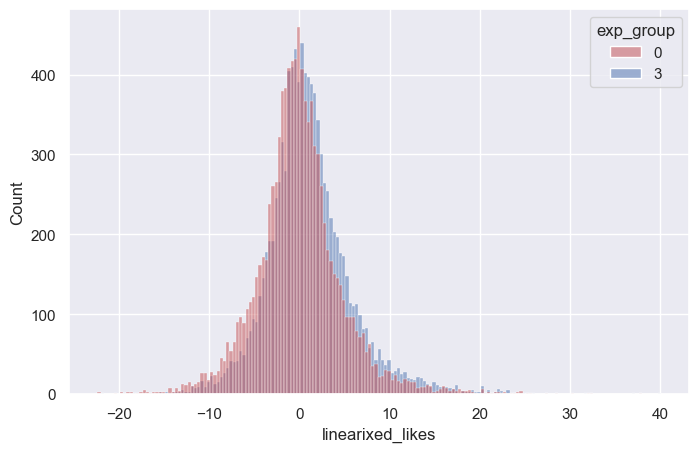

In [14]:
# Построим гистограммы распределения CTR линеаризированных лайков по группам 0 и 3

sns.histplot(data=df_linearixed_gr_1, 
             x='linearixed_likes', 
             hue='exp_group', 
             palette=['r', 'b'], 
             alpha=0.5, 
             kde=False)

Проанализируем тест между группами 0 и 3 по метрике линеаризованных лайков

In [10]:
# t-test group 0 and 3, linearixed_CTR

ttest_gr_1_line = stats.ttest_ind(df_linearixed_gr_1[df_linearixed_gr_1.exp_group == 0].linearixed_likes, 
                                  df_linearixed_gr_1[df_linearixed_gr_1.exp_group == 3].linearixed_likes,
                                  equal_var=False)
ttest_gr_1_line

Ttest_indResult(statistic=-16.18591163811859, pvalue=1.499460995637754e-58)

In [11]:
# t-test group 0 and 3, CTR

ttest_gr_1_ctr = stats.ttest_ind(df_linearixed_gr_1[df_linearixed_gr_1.exp_group == 0].ctr, 
                                 df_linearixed_gr_1[df_linearixed_gr_1.exp_group == 3].ctr, 
                                 equal_var=False)
ttest_gr_1_ctr

Ttest_indResult(statistic=-13.971394576179117, pvalue=3.76642269628566e-44)

In [12]:
ttest_gr_1_line.pvalue < ttest_gr_1_ctr.pvalue

True

P-value CTR линеаризированных лайков стало меньше, чем у обычного CTR. И само распределение уже стало непрерывным и похоже на нормальное.

Получается, что тест на новой метрике "прокрасился", соответственно, мы можем заключить, что изменения есть и в исходной метрике
(т.е. и в лайках, и в CTR)

In [17]:
df_linearixed_gr_1.groupby('exp_group', as_index=False).agg({'user_id':'count', 
                                                             'likes':'sum', 
                                                             'views':'sum', 
                                                             'ctr':'mean', 
                                                             'linearixed_likes':'mean'})

,exp_group,user_id,likes,views,ctr,linearixed_likes
0,0,9920,140714,670584,0.216781,-0.010952
1,3,10002,151327,668975,0.233165,1.084008


По абсолютным значениям мы также видим более выраженную динамику: если обычный CTR отличается незначительно, то по линеаризированному мы видим значительную разницу между группами

**2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?**

In [18]:
# Считаем общий CTR в контрольной группе 1 и линеаризованные лайки в группах 1 и 2

quest_linearixed_2 = """
                        SELECT 
                            exp_group, 
                            user_id, 
                            likes, 
                            views, 
                            ctr, 
                            ctr_control, 
                            round(likes - (ctr_control * views), 2) as linearixed_likes
                        FROM
                          (
                          SELECT 
                              exp_group, 
                              user_id,
                              SUM(action = 'like') as likes,
                              SUM(action = 'view') as views,
                              round(likes/views, 2) as ctr
                          FROM 
                              simulator_20231020.feed_actions
                          WHERE 
                              toDate(time) BETWEEN '2023-09-28' AND '2023-10-04'
                              AND exp_group in (1, 2)
                          GROUP BY 
                              exp_group, 
                              user_id
                          ) as t1
                        CROSS JOIN
                          (
                          SELECT 
                              round(SUM(action = 'like')/SUM(action = 'view'), 2) as ctr_control
                          FROM 
                              simulator_20231020.feed_actions
                          WHERE 
                              toDate(time) BETWEEN '2023-09-28' AND '2023-10-04'
                              AND exp_group = 1
                          GROUP BY 
                              exp_group
                          ) as common_ctr
                        """

df_linearixed_gr_2 = ph.read_clickhouse(quest_linearixed_2, connection=connection)
df_linearixed_gr_2.head()

,exp_group,user_id,likes,views,ctr,ctr_control,linearixed_likes
0,1,109963,3,15,0.20,0.21,-0.15
1,1,26117,32,141,0.23,0.21,2.39
2,1,138232,18,73,0.25,0.21,2.67
3,1,18392,7,32,0.22,0.21,0.28
4,1,26295,39,141,0.28,0.21,9.39


<AxesSubplot:xlabel='linearixed_likes', ylabel='Count'>

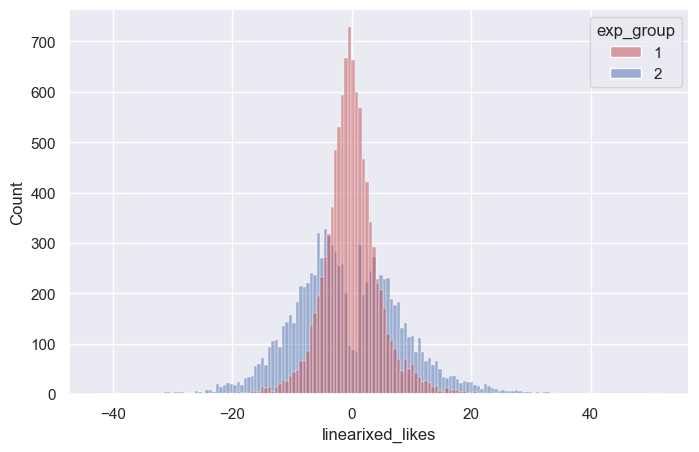

In [19]:
# Построим гистограммы распределения CTR линеаризированных лайков по группам 1 и 2

sns.histplot(data=df_linearixed_gr_2, 
             x='linearixed_likes', 
             hue='exp_group', 
             palette=['r', 'b'], 
             alpha=0.5, 
             kde=False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

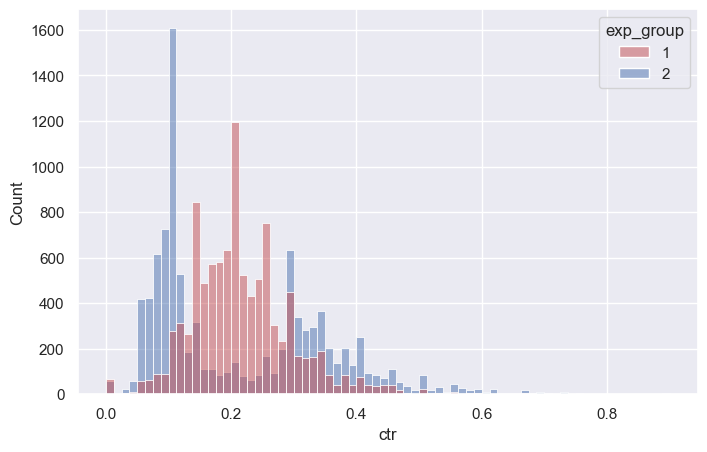

In [20]:
# Построим гистограммы распределения CTR по группам 1 и 2

sns.histplot(data=df_linearixed_gr_2, 
             x='ctr', 
             hue='exp_group', 
             palette=['r', 'b'], 
             alpha=0.5, 
             kde=False)

In [21]:
# t-test group 1 and 2, linearixed CTR

ttest_gr_2_line = stats.ttest_ind(df_linearixed_gr_2[df_linearixed_gr_2.exp_group == 1].linearixed_likes, 
                                  df_linearixed_gr_2[df_linearixed_gr_2.exp_group == 2].linearixed_likes,
                                  equal_var=False)
ttest_gr_2_line

Ttest_indResult(statistic=5.9334200301653715, pvalue=3.034569921316535e-09)

In [22]:
# t-test group 1 and 2, CTR

ttest_gr_2_ctr = stats.ttest_ind(df_linearixed_gr_2[df_linearixed_gr_2.exp_group == 1].ctr, 
                                 df_linearixed_gr_2[df_linearixed_gr_2.exp_group == 2].ctr,
                                 equal_var=False)
ttest_gr_2_ctr

Ttest_indResult(statistic=0.39592337412325357, pvalue=0.6921668985029372)

p-value CTR линеаризированных лайков во второй группе также стало меньше и показало, что разница между выборками 1 и 2 статистически значима.

In [25]:
df_linearixed_gr_2.groupby('exp_group', as_index=False).agg({'user_id':'count', 
                                                             'likes':'sum', 
                                                             'views':'sum', 
                                                             'ctr':'mean', 
                                                             'linearixed_likes':'mean'})

,exp_group,user_id,likes,views,ctr,linearixed_likes
0,1,10020,140339,669543,0.216735,-0.026450
1,2,9877,132056,659454,0.216078,-0.650941


В абсолютным значениям мы тоже видим весомые различия. Как мы знаем, в группе 2 применялся новый алгоритм рекомендации, и по снижению ключевых метрик мы еще раз убеждаемся, что новый алгоритм  не оправдывает первоначальных ожиданий, а именно - метрика CTR не увеличивается